## 1. Python Environment Setup and Libraries Installation

```python
!pip install rasterio geopandas numpy matplotlib earthengine-api pyproj


In [ ]:
#!pip install rasterio geopandas numpy matplotlib earthengine-api pyproj

In [1]:
import os
import time
import numpy as np
import geopandas as gpd
import ee
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.features import geometry_mask
import matplotlib.pyplot as plt
from rasterio.merge import merge

## 2. Downloading Landsat Scenes with Google Earth Engine

This script downloads Landsat scenes using Google Earth Engine. It authenticates with Earth Engine, filters Landsat-8 collections based on location, cloud cover, and scene parameters, and exports the NIR and Red bands to Google Drive for each specified scene.

### Prerequisites

- Authentication with Google Earth Engine is required.
- Ensure access to Google Drive for exporting images.

### Steps

1. **Authenticate with Google Earth Engine**: This step requires authentication to access Google Earth Engine.

2. **Define the Scenes to Download**: Specify the scenes to download by providing the path and row numbers.

3. **Filter Landsat-8 Collection**: Filter the Landsat-8 image collection based on location, cloud cover, and scene parameters.

4. **Export Bands to Google Drive**: Export the NIR and Red bands to Google Drive for each specified scene.

### Notes

- The script uses the Earth Engine Python API for accessing and processing Landsat imagery.
- The exported files are saved in the specified output directory with names indicating the path and row numbers.



In [ ]:
# Authenticate with Google Earth Engine
ee.Authenticate()
ee.Initialize()

# Function to export an Earth Engine image to Google Drive
def export_to_drive(image, description, folder, scale):
    task = ee.batch.Export.image.toDrive(image=image, description=description, folder=folder, scale=scale)
    task.start()
    while task.status()['state'] in ['READY', 'RUNNING']:
        time.sleep(10)  # Check task status every 10 seconds
    if task.status()['state'] == 'COMPLETED':
        print(f'Export task for {description} completed successfully.')
        return os.path.join(folder, description + '.tif')
    else:
        print(f'Error exporting {description} to Google Drive. Check the task status.')
        return None

# Define the scenes to download
scenes = [
    {'path': 129, 'row': 50},
    {'path': 129, 'row': 51}
]

# Define the cloud cover threshold
cloud_cover_max = 15

# Loop through each scene
for scene in scenes:
    path = scene['path']
    row = scene['row']
    
    # Filter LANDSAT-8 collection
    collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') \
        .filterBounds(ee.Geometry.Point(100.5018, 13.7563)) \
        .filter(ee.Filter.eq('WRS_PATH', path)) \
        .filter(ee.Filter.eq('WRS_ROW', row)) \
        .filter(ee.Filter.lt('CLOUD_COVER', cloud_cover_max)) \
        .sort('CLOUD_COVER', True)

    # Get the first image from the collection
    image = ee.Image(collection.first())

    # Export NIR and Red bands to Google Drive
    output_dir = 'landsat_downloads'
    nir_band_path = export_to_drive(image.select('B5'), f'nir_band_{path}_{row}', output_dir, 30)
    red_band_path = export_to_drive(image.select('B4'), f'red_band_{path}_{row}', output_dir, 30)


## 3. Download landsat 8 images from Google Drive to Local Path

## 4. Merging NIR and Red Bands from Two Scenes

In [2]:
# Directory containing downloaded NIR and Red band files
input_dir = 'landsat_downloads'

# List to store NIR and Red band files
nir_band_files = []
red_band_files = []

# Iterate over files in the input directory
for file in os.listdir(input_dir):
    if file.startswith('nir_band') and file.endswith('.tif'):
        nir_band_files.append(os.path.join(input_dir, file))
    elif file.startswith('red_band') and file.endswith('.tif'):
        red_band_files.append(os.path.join(input_dir, file))

# Open NIR bands as datasets
nir_datasets = [rasterio.open(file) for file in nir_band_files]

# Merge NIR bands
merged_nir, merged_nir_transform = merge(nir_datasets, nodata=np.nan)

# Open Red bands as datasets
red_datasets = [rasterio.open(file) for file in red_band_files]

# Merge Red bands
merged_red, merged_red_transform = merge(red_datasets, nodata=np.nan)

# Define output file names
output_nir = os.path.join(input_dir, 'nir_band_merged.tif')
output_red = os.path.join(input_dir, 'red_band_merged.tif')

# Write merged NIR band to a new GeoTIFF file
with rasterio.open(output_nir, 'w', driver='GTiff', width=merged_nir.shape[2], height=merged_nir.shape[1],
                   count=1, dtype=merged_nir.dtype, crs=nir_datasets[0].crs, transform=merged_nir_transform,
                   nodata=np.nan) as dst:
    dst.write(merged_nir)

# Write merged Red band to a new GeoTIFF file
with rasterio.open(output_red, 'w', driver='GTiff', width=merged_red.shape[2], height=merged_red.shape[1],
                   count=1, dtype=merged_red.dtype, crs=red_datasets[0].crs, transform=merged_red_transform,
                   nodata=np.nan) as dst:
    dst.write(merged_red)

print("Merged NIR band saved as:", output_nir)
print("Merged Red band saved as:", output_red)


Merged NIR band saved as: landsat_downloads/nir_band_merged.tif
Merged Red band saved as: landsat_downloads/red_band_merged.tif


## 5. Clipping and Analyzing NDVI within Bangkok Boundary


### Calculate NDVI

In [6]:
import rasterio
import numpy as np

def calculate_ndvi(nir_band_path, red_band_path, ndvi_output_path):
    # Open NIR band
    with rasterio.open(nir_band_path) as nir_src:
        nir_band_data = nir_src.read(1).astype(np.float32)
        # Set values less than 0 and greater than 10000 to NaN
        nir_band_data = np.where((nir_band_data < 0) | (nir_band_data > 10000), np.nan, nir_band_data)

    # Open Red band
    with rasterio.open(red_band_path) as red_src:
        red_band_data = red_src.read(1).astype(np.float32)

        # Set values less than 0 and greater than 10000 to NaN
        red_band_data = np.where((red_band_data < 0) | (red_band_data > 10000), np.nan, red_band_data)

    # Calculate NDVI
    numerator = nir_band_data - red_band_data
    denominator = nir_band_data + red_band_data
    ndvi = np.divide(numerator, denominator, out=np.full_like(numerator, np.nan), where=denominator != 0)

    # Get metadata from one of the input files
    with rasterio.open(nir_band_path) as src:
        profile = src.profile

    # Update metadata for NDVI band
    profile.update(
        dtype=rasterio.float32,
        count=1)

    # Write NDVI raster to disk
    with rasterio.open(ndvi_output_path, 'w', **profile) as dst:
        dst.write(ndvi, 1)

if __name__ == "__main__":
    # Define paths to NIR and Red band GeoTIFF files
    nir_band_path = 'landsat_downloads/nir_band_merged.tif'
    red_band_path = 'landsat_downloads/red_band_merged.tif'
    ndvi_output_path = 'ndvi/ndvi.tif'

    # Call the function to calculate NDVI and save it to a file
    calculate_ndvi(nir_band_path, red_band_path, ndvi_output_path)


### Clip NDVI with Bangkok boundary and export to Geotiff

In [27]:
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.mask import mask
from shapely.geometry import box

def clip_ndvi_with_boundary(ndvi_path, boundary_shp_path, clipped_ndvi_output_path):
    # Open NDVI raster
    with rasterio.open(ndvi_path) as ndvi_src:
        ndvi_crs = ndvi_src.crs
        ndvi_transform = ndvi_src.transform

        # Load Bangkok boundary shapefile and filter only Bangkok
        bangkok_boundary = gpd.read_file(boundary_shp_path)
        bangkok_boundary = bangkok_boundary[bangkok_boundary['NAME_1'] == 'Bangkok Metropolis']

        # Convert the CRS of the shapefile to match the CRS of the NDVI raster
        bangkok_boundary = bangkok_boundary.to_crs(ndvi_crs)

        # Define a function to clip NDVI with boundary
        def clip_ndvi_with_boundary(ndvi_src, boundary_geom, boundary_crs):
            try:
                # Clip NDVI with boundary
                clipped_ndvi, transform = mask(dataset=ndvi_src,
                                            shapes=[boundary_geom],
                                            crop=True,
                                            nodata=np.nan)

                # Reshape the clipped_ndvi array to remove extra dimensions
                clipped_ndvi = clipped_ndvi.squeeze()

                # Update metadata for the clipped NDVI band
                clipped_profile = {
                    'driver': 'GTiff',
                    'height': clipped_ndvi.shape[0],  # Use the height of the clipped data
                    'width': clipped_ndvi.shape[1],   # Use the width of the clipped data
                    'count': 1,                        # Specify the number of bands
                    'dtype': rasterio.float32,
                    'crs': boundary_crs,
                    'transform': transform
                }

                return clipped_ndvi, clipped_profile

            except Exception as e:
                # Log the exception for debugging
                print(f"Error occurred: {e}")
                raise

        # Verify overlap between raster bounds and shape bounds
        raster_bbox = box(*ndvi_src.bounds)
        shape_bbox = box(*bangkok_boundary.geometry.total_bounds)
        if not raster_bbox.intersects(shape_bbox):
            raise ValueError("Input shape does not overlap raster.")

        # Clip NDVI with Bangkok boundary
        clipped_ndvi, clipped_profile = clip_ndvi_with_boundary(ndvi_src, bangkok_boundary.geometry.iloc[0], ndvi_crs)

        # Write clipped NDVI raster to disk
        with rasterio.open(clipped_ndvi_output_path, 'w', **clipped_profile) as dst:
            dst.write(clipped_ndvi, 1)

if __name__ == "__main__":
    ndvi_path = 'ndvi/ndvi.tif'
    boundary_shp_path = 'thailand-map-master/shapefiles/thailand-provinces.shp'
    clipped_ndvi_output_path = 'ndvi/ndvi_clip.tif'

    clip_ndvi_with_boundary(ndvi_path, boundary_shp_path, clipped_ndvi_output_path)


### Plot NDVI and export plot to png

/var/folders/pp/1y1_xkbj3v7ghykf_mbb2tl80000gn/T/ipykernel_4359/2994602264.py:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(png_path, dpi=300, bbox_inches='tight', pad_inches=0)
/var/folders/pp/1y1_xkbj3v7ghykf_mbb2tl80000gn/T/ipykernel_4359/2994602264.py:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(png_path, dpi=300, bbox_inches='tight', pad_inches=0)
/var/folders/pp/1y1_xkbj3v7ghykf_mbb2tl80000gn/T/ipykernel_4359/2994602264.py:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(png_path, dpi=300, bbox_inches='tight', pad_inches=0)
/var/folders/pp/1y1_xkbj3v7gh

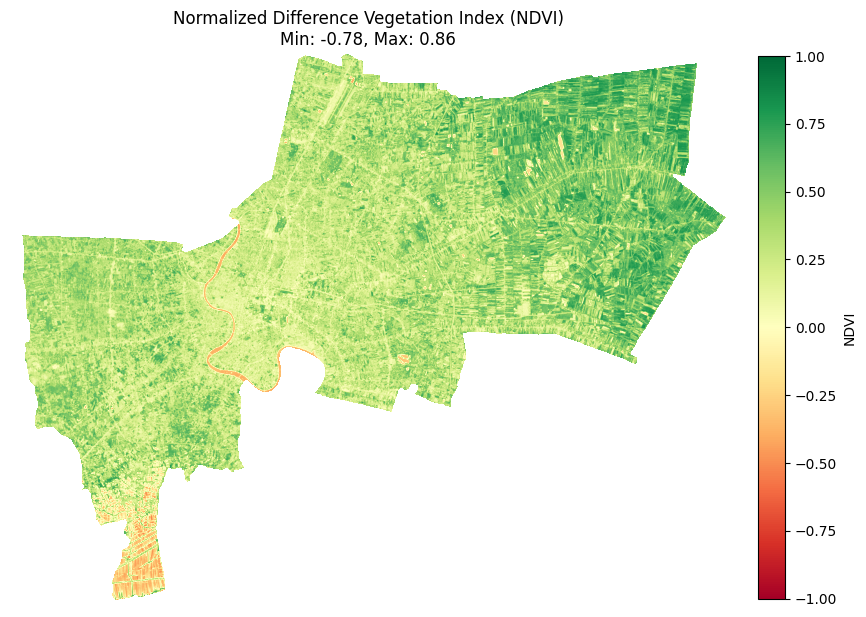

Mean NDVI: 0.3490648270
Area of Bangkok: 3,270,426,285.43 square meter


In [28]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

def plot_ndvi(ndvi_path, bangkok_boundary_shp_path, png_path):
    # Open NDVI GeoTIFF file
    with rasterio.open(ndvi_path) as src:
        ndvi = src.read(1, masked=True)  # Read NDVI band
        ndvi_crs = src.crs  

    # Plot NDVI
    plt.figure(figsize=(10, 10))
    img = plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(img, fraction=0.035, pad=0.04, label='NDVI')
    plt.title(f'Normalized Difference Vegetation Index (NDVI)\nMin: {np.nanmin(ndvi):.2f}, Max: {np.nanmax(ndvi):.2f}')
    plt.axis('off')
        
    # Save the plot without using deprecated arguments
    plt.savefig(png_path, dpi=300, bbox_inches='tight', pad_inches=0)
    
    # Show the plot
    plt.show()
    
    # Open Bangkok boundary shapefile
    bangkok_boundary = gpd.read_file(bangkok_boundary_shp_path)
    
    # Convert the boundary shapefile to EPSG 4326 (WGS84)
    bangkok_boundary = bangkok_boundary.to_crs('EPSG:4326')
    
    # Calculate mean NDVI and area in square meters of Bangkok
    mean_ndvi = np.nanmean(ndvi)
    area_sq_meter = bangkok_boundary.geometry.to_crs(ndvi_crs).area.values[0]

    # Print results
    print("Mean NDVI: {:,.10f}".format(mean_ndvi))
    print("Area of Bangkok: {:,.2f} square meter".format(area_sq_meter))
    
if __name__ == "__main__":
    # Paths
    png_path = 'ndvi/ndvi_plot.png'
    ndvi_path = 'ndvi/ndvi_clip.tif'
    bangkok_boundary_shp_path = 'thailand-map-master/shapefiles/thailand-provinces.shp'

    # Call the function
    plot_ndvi(ndvi_path, bangkok_boundary_shp_path, png_path)
